<a href="https://colab.research.google.com/github/Shuo-Zh/dl/blob/main/%E5%BA%8F%E5%88%97%E6%A8%A1%E5%9E%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 序列模型
p(a, b)=p(a)* p(b|a)=p(b)* p(a|b)

p(x_t|x1,...X_t-1) = p(x_t|f(x1,...x_t-1) 自回归模型

## 马尔可夫假设
当前数据 只跟 t 个过去数据点相关

## 潜变量模型
引入潜变量h_t来表示过去信息 h_t=f(x,...x_t-1)
- x_t = p(x_t|h_t)

# 总结
- 时序模型中，当前数据和之前观察到的数据相关
- 自回归模型使用自身过去数据来预测未来
- 马尔可夫假设当前只跟最近少数数据相关，从而简化模型
- 潜变量模型使用潜变量来概括历史信息【RNN】

In [2]:
pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 88.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.8 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
  Attempting uninstall: matplotlib
    F

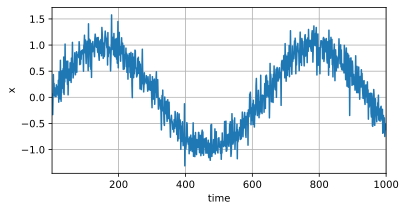

In [14]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

T = 1000  # 总共产生1000个点
time = tf.range(1, T + 1, dtype=tf.float32)
x = tf.sin(0.01 * time) + tf.random.normal([T], 0, 0.2)
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [16]:
# 将数据映射为 y_t = x_t 和 x_t = [x_t-tau,...,x_t-1]
tau = 4
features = tf.Variable(tf.zeros((T - tau, tau)))
for i in range(tau):
    features[:, i].assign(x[i: T - tau + i])
labels = tf.reshape(x[tau:], (-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [17]:
# 定义一个简单的多层感知机，RELU损失函数和平方损失
def get_net():
    net = tf.keras.Sequential([tf.keras.layers.Dense(10, activation='relu'),
                              tf.keras.layers.Dense(1)])
    return net

# 最小均方损失。注意：MeanSquaredError计算平方误差时不带系数1/2
loss = tf.keras.losses.MeanSquaredError()

In [18]:
# 训练模型
def train(net, train_iter, loss, epochs, lr):
    trainer = tf.keras.optimizers.Adam()
    for epoch in range(epochs):
        for X, y in train_iter:
            with tf.GradientTape() as g:
                out = net(X)
                l = loss(y, out)
                params = net.trainable_variables
                grads = g.gradient(l, params)
            trainer.apply_gradients(zip(grads, params))
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.059031
epoch 2, loss: 0.056899
epoch 3, loss: 0.055886
epoch 4, loss: 0.053669
epoch 5, loss: 0.052464


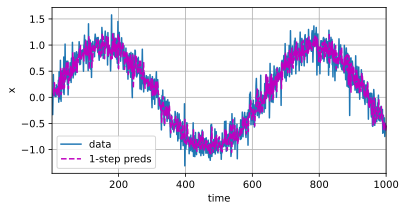

In [19]:
# 预测 - 单步预测
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.numpy(), onestep_preds.numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

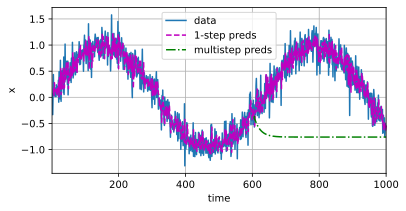

In [20]:
# 我们必须使用我们自己的预测（而不是原始数据）来进行多步预测。 让我们看看效果如何。
multistep_preds = tf.Variable(tf.zeros(T))
multistep_preds[:n_train + tau].assign(x[:n_train + tau])
for i in range(n_train + tau, T):
    multistep_preds[i].assign(tf.reshape(net(
        tf.reshape(multistep_preds[i - tau: i], (1, -1))), ()))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.numpy(), onestep_preds.numpy(),
          multistep_preds[n_train + tau:].numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

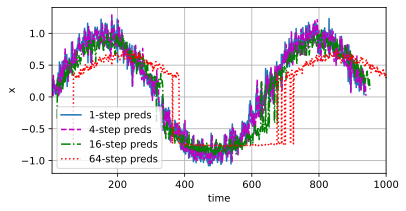

In [21]:
# ，通过对整个序列预测的计算， 让我们更仔细地看一下
max_steps = 64

features = tf.Variable(tf.zeros((T - tau - max_steps + 1, tau + max_steps)))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i].assign(x[i: i + T - tau - max_steps + 1].numpy())

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i].assign(tf.reshape(net((features[:, i - tau: i])), -1))

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))